Tutorial 3: Inversions
======================

We've covered `Mapper``., which, if I haven't emphasised it enough yet, map things. Now, we're going to look at how we
can use these `Mapper`'s (which map things) to reconstruct the source galaxy - I hope you're excited!

In [1]:
#%matplotlib inline
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


we'll use the same strong lensing data as the previous tutorial, where:

 - The lens galaxy's light is omitted.
 - The lens galaxy's total mass distribution is an `EllipticalIsothermal`.
 - The source galaxy's `LightProfile` is an `EllipticalSersic`.

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

Lets create an annular `Mask2D` which traces the stongly lensed source ring.

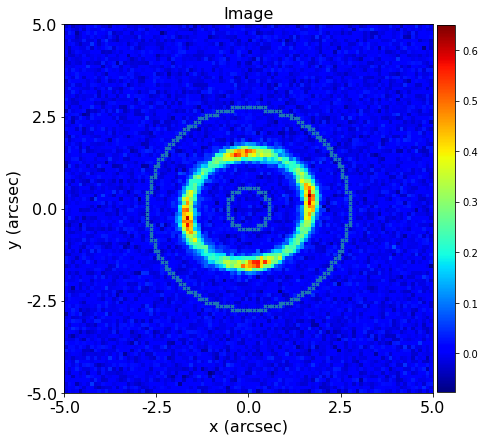

In [3]:
mask = al.Mask2D.circular_annular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=1,
    inner_radius=0.5,
    outer_radius=2.8,
)

visuals_2d = aplt.Visuals2D(mask=mask)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging, visuals_2d=visuals_2d)
imaging_plotter.figures(image=True)

Next, lets set the `Imaging` and `Mask2D` up as a `MaskedImaging` object and setup a `Tracer` using the input lens 
galaxy model (we don't need to provide the source's `LightProfile`, as we're using a `Mapper` to reconstruct it).

In [4]:
masked_imaging = al.MaskedImaging(
    imaging=imaging, mask=mask, settings=al.SettingsMaskedImaging(sub_size=2)
)

lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0),
        einstein_radius=1.6,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, phi=45.0),
    ),
    shear=al.mp.ExternalShear(elliptical_comps=(0.05, 0.05)),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=1.0)])

source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_imaging.grid)[1]

we'll use another rectangular `Pixelization` and `Mapper` to perform the reconstruction.

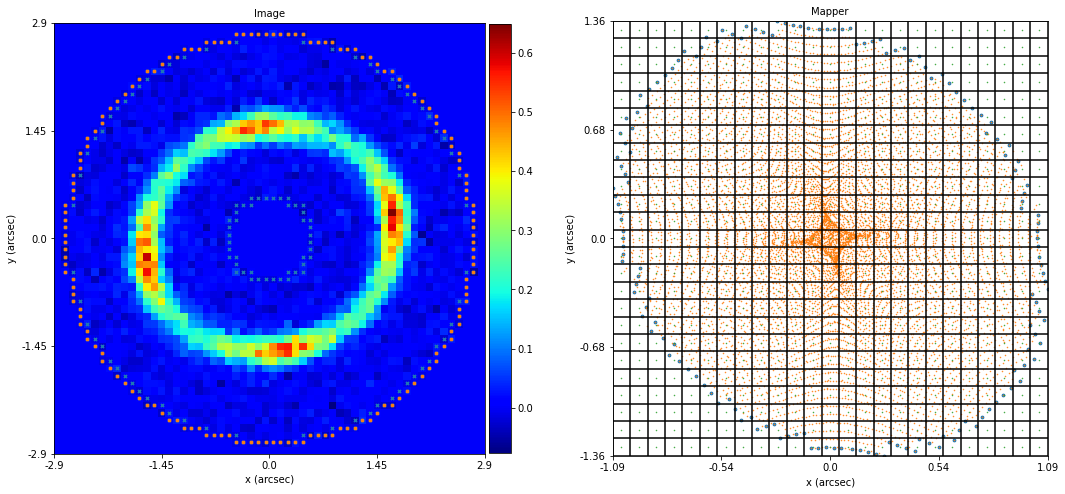

In [5]:
rectangular = al.pix.Rectangular(shape=(25, 25))

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

include_2d = aplt.Include2D(mask=True, mapper_source_grid_slim=True)

mapper_plotter = aplt.MapperPlotter(mapper=mapper, include_2d=include_2d)
mapper_plotter.subplot_image_and_mapper(image=masked_imaging.image)

And now, finally, we're going to use our `Mapper` to invert the image using an `Inversion`. I'll explain how this 
works in a second - but lets just go ahead and use the `Inversion` first. (Ignore the `regularization` input below for 
now, we'll cover this in the next tutorial).

In [6]:
inversion = al.Inversion(
    masked_dataset=masked_imaging,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=1.0),
)

Our `Inversion` has a reconstructed image and `Pixeilzation`, whcih we can plot using an `InversionPlotter`

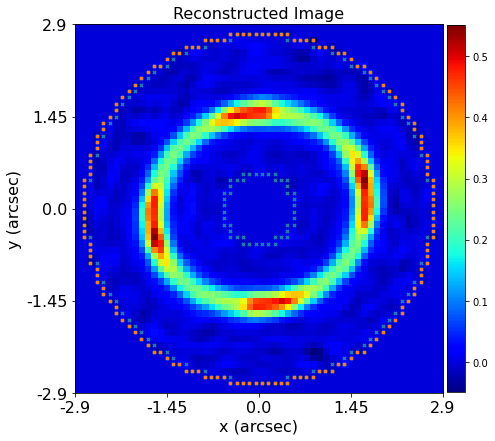

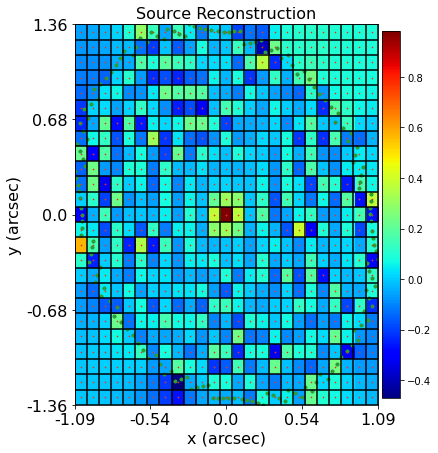

In [7]:
include_2d = aplt.Include2D(mask=True)

inversion_plotter = aplt.InversionPlotter(inversion=inversion, include_2d=include_2d)
inversion_plotter.figures(reconstructed_image=True, reconstruction=True)

And there we have it, we've successfully reconstructed, or, *inverted*, our source using the mapper`s rectangular 
grid. Whilst this source was simple (a blob of light in the centre of the source-plane), `Inversion`'s come into their 
own when fitting sources with complex morphologies. Infact, given we're having so much fun inverting things, lets 
invert a really complex source!

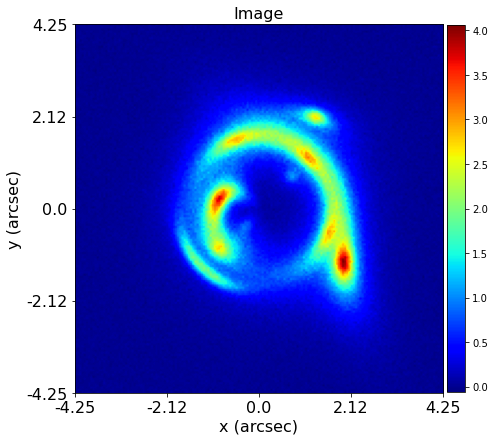

In [8]:
dataset_name = "mass_sie__source_sersic_x4"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.05,
)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.figures(image=True)

This code is doing all the the same as above (setup the `Mask2D`, `Galaxy`'s `Tracer`, `Mapper`, ec.).

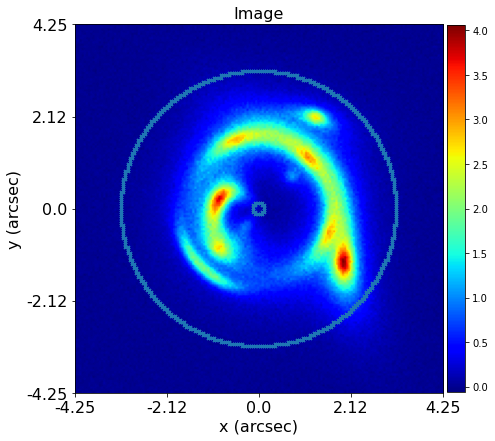

In [9]:
mask = al.Mask2D.circular_annular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=1,
    inner_radius=0.1,
    outer_radius=3.2,
)

visuals_2d = aplt.Visuals2D(mask=mask)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging, visuals_2d=visuals_2d)
imaging_plotter.figures(image=True)

masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask)

lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0), einstein_radius=1.6, elliptical_comps=(0.17647, 0.0)
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=1.0)])

source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_imaging.grid)[1]

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

inversion = al.Inversion(
    masked_dataset=masked_imaging,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=1.0),
)

Lets inspect the complex source reconstruction.

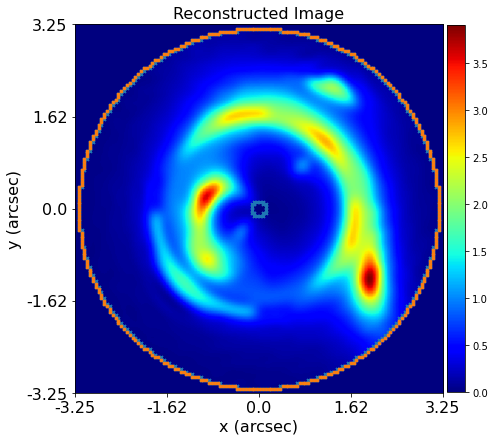

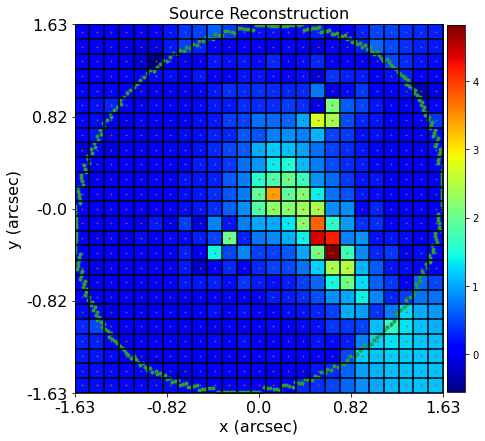

In [10]:
inversion_plotter = aplt.InversionPlotter(inversion=inversion, include_2d=include_2d)
inversion_plotter.figures(reconstructed_image=True, reconstruction=True)

Pretty great, huh? If you ran the complex source pipeline, you'll remember that getting a model image that looked that 
good simply *was not possible*. With an `Inversion`, we can do it with ease and without fitting 30+ parameters!

Lets discuss how an `Inversion` actually works. The explanation I give below is overly-simplified. I'm avoiding the 
technical details of how an `Inversion` *actually* works. To be good at lens modeling you don't need to understand the 
nitty-gritty details of linear inversions, you just need an instinct for how to use them as a tool to model lenses.

Nevertheless, I know a lot of you hate `black-boxes`, or have an interest in linear algrebra. If you're that way 
inclined, then checkout the documentation of the autolens source code for more information. In particular, you should 
look at the following functions in the project PyAutoArray:

autoarray.inversions.mappers.mapping_matrix
autoarray.opterators.convolution.convolve_mapping_matrix
autoarray.opterators.inversions.regularization.Regularization
autoarray.opterators.inversions.inversions.Inversion

To begin, lets consider some random mappings between our mapper`s source-pixels and the image.

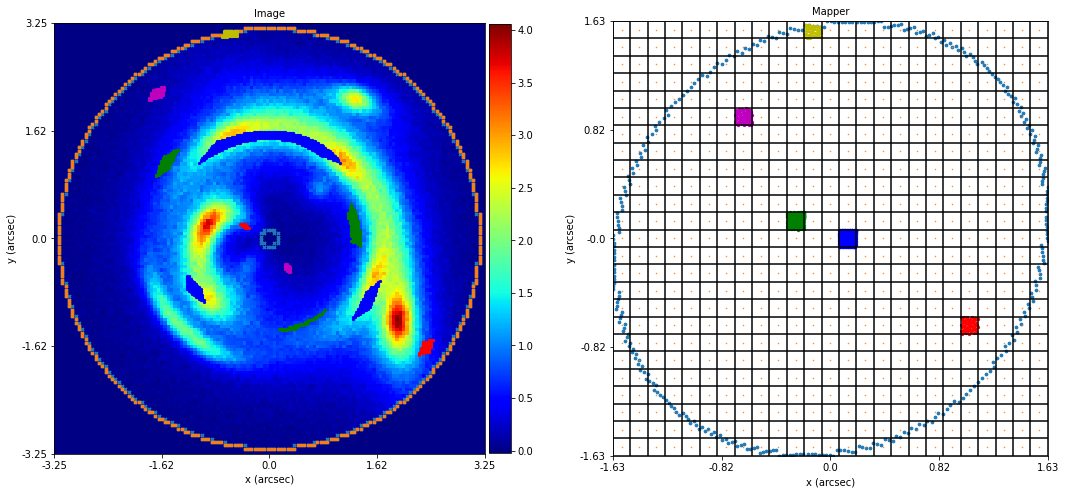

In [11]:
visuals_2d = aplt.Visuals2D(pixelization_indexes=[[445], [285], [313], [132], [11]])

mapper_plotter = aplt.MapperPlotter(
    mapper=mapper, visuals_2d=visuals_2d, include_2d=include_2d
)
mapper_plotter.subplot_image_and_mapper(image=masked_imaging.image)

These mappings are known before the `Inversion`, which means pre-inversion we know two key pieces of information:

 1) The mappings between every source-pixel and sets of image-pixels.
 2) The flux values in every observed image-pixel, which are the values we want to fit successfully.

It turns out that with these two pieces of information we can linearly solve for the set of source-pixel fluxes that 
best-fit (e.g. maximize the log likelihood of) our observed image. Essentially, we set up the mapping between source and 
image pixels as a large matrix and solve for the source-pixel fluxes in an analogous fashion to how you would solve a 
set of simultaneous linear equations. This process is called a `linear inversion`.

There are three more things about a linear `Inversion` that are worth knowing:

 1) We've discussed the image sub-grid before, which splits each image-pixel into a sub-pixel. If a sub-grid is 
 used, it is the mapping between every sub-pixel and source-pixel that is computed and used to perform the 
 `Inversion`. This prevents aliasing effects degrading the image reconstruction, and, as a rule of thumb, I 
 would suggest you use sub-gridding of degree 2x2.

 2) When fitting using `LightProfile`'s we discussed how a `model_image` was generated by blurring them with the 
 data's PSF. A similar blurring operation is incorporated into the `Inversion`, such that the reconstructed 
 image and source fully account for the telescope optics and effect of the PSF.

 3) The inversion`s solution is regularized. But wait, that`s what we'll cover in the next tutorial!

Finally, let me show you how easy it is to fit an image with an `Inversion` using a `FitImaging` oboject. Instead of 
giving the source galaxy a `LightProfile`, we give it a `Pixelization` and `Regularization`, and pass it to a `Tracer`.

In [12]:
source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=1.0),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

Then, like before, we pass the `MaskedImaging` and `Tracer` to a `FitImaging` object. Indeed, we see some 
pretty good looking residuals - we're certainly fitting the lensed source accurately!

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


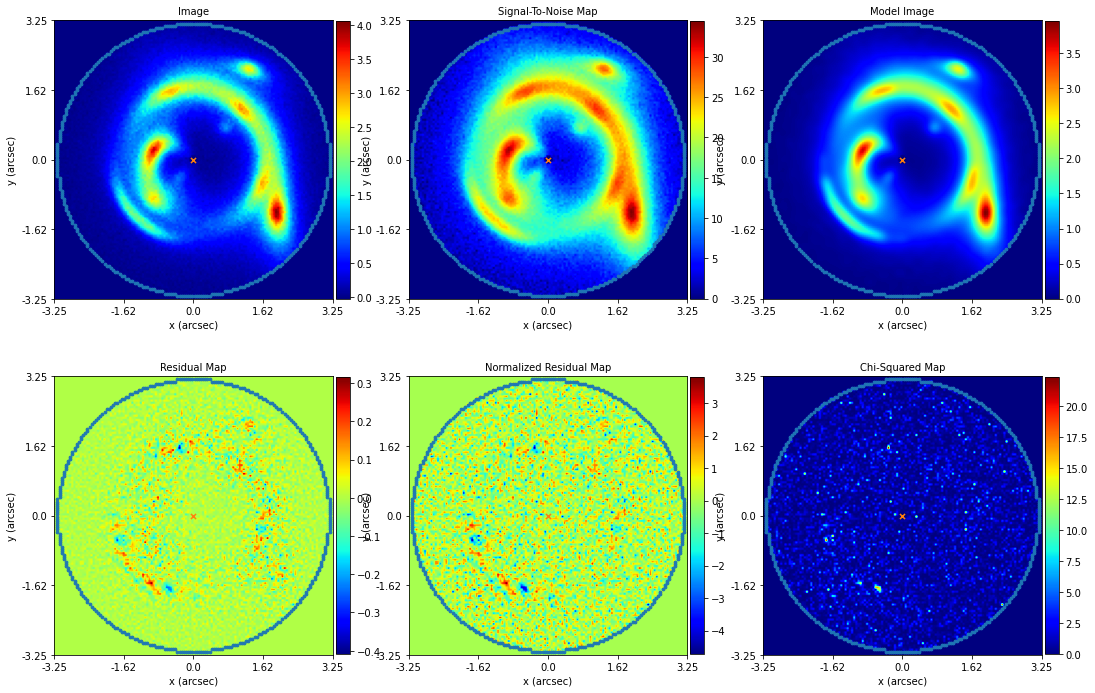

In [13]:
fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

include_2d = aplt.Include2D(mask=True)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()

And, we're done, here are a few questions to get you thinking about `Inversion``.:

 1) The `Inversion` provides the maximum log likelihood solution to the observed image. Is there a problem with seeking 
 the `best-fit`? Is there a risk that we're going to fit other things in the image than just the lensed source 
 galaxy? What happens if you reduce the `regularization_coefficient` above to zero?

 2) The exterior pixels in the `Rectangular` `Grid2D`.have no image-pixels in them. However, they are still given a 
 reconstructed flux. If this value isn't` coming from a util to an image-pixel, where is it be coming from?